In [7]:
from roboflow import Roboflow
rf = Roboflow(api_key="ALlrOsOChWfSloDPfrqL")
project = rf.workspace("personal-protective-equipment").project("ppes-kaxsi")
dataset = project.version(4).download("tensorflow")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to PPEs-4 in tensorflow:: 100%|██████████████████| 11984/11984 [01:07<00:00, 178.41it/s]


In [4]:
#importing libraries
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import skimage
import cv2
import os

In [6]:
df_description_train = pd.read_csv("C:/Data Science/Projekty/Surveily zadanie/PPEs-4/train/_annotations.csv")

In [8]:
df_description_train.columns

Index(['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')

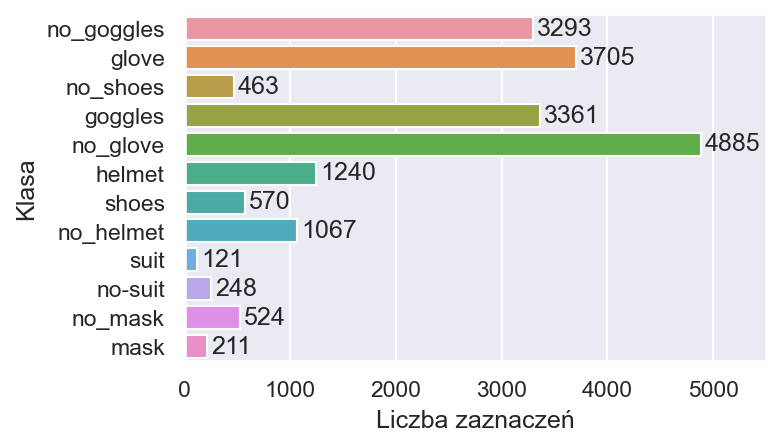

In [243]:
sn.set(rc={"figure.dpi":150, 'savefig.dpi':150})
fig, ax = plt.subplots(figsize=(5,3))
sn.countplot(data = df_description_train, y="class")
ax.set_ylabel("Klasa")
ax.set_xlabel("Liczba zaznaczeń")
ax.bar_label(ax.containers[0], padding=2)
ax.set_xlim(0,5500)

plt.show()

In [10]:
df_description_train["class"].unique()

array(['no_goggles', 'glove', 'no_shoes', 'goggles', 'no_glove', 'helmet',
       'shoes', 'no_helmet', 'suit', 'no-suit', 'no_mask', 'mask'],
      dtype=object)

### Widzimy, że w naszym zbiorze danych jest 12 różnych kategorii. Klasy są bardzo niezbalansowane: 4 z nich występują powyżej 3000 razy, a pozostałe poniżej 1300 razy. Przed treningiem modelu konieczne będzie doprowadzenie do większej równowagi między liczbami występowań etykiet.

# Liczba wszystkich zaznaczeń

In [11]:
len(df_description_train)

19688

# Liczba zdjęć

In [12]:
len(df_description_train.groupby("filename"))

9611

# Liczba różnych zaznaczeń na pojedynczym zdjęciu

In [245]:
x = df_description_train["filename"].value_counts().reset_index()
x.columns = ["filename", "number of selections"]
x

filename  number of selections
0     005419_jpg.rf.fbf5dcfa0c255e44e9dec17b9c164813...                    13
1     005393_jpg.rf.1acebd57208fedf1841c5e6886022fac...                    12
2     005514_jpg.rf.ae428d32f1c6e007516458b26c8a01eb...                    12
3     005378_jpg.rf.189c396041443504e68ad0c48baddd9e...                    10
4     005442_jpg.rf.3fd474d2f744f2e275bcfbcb7e703465...                    10
...                                                 ...                   ...
9606  frame3915_jpg.rf.12007e1fee70f5c0ec7c55550e5a6...                     1
9607  kp1163_jpg.rf.124966f2a06b3610289312640330b46b...                     1
9608  PPE_Data_331_jpg.rf.124718794c511d8d8670b58236...                     1
9609   kp54_jpg.rf.123c8c1bc1bc8a893588c3167b8400d0.jpg                     1
9610  p11377_jpg.rf.c74ca95c7bef276e0005b6e7f6e7bdc1...                     1

[9611 rows x 2 columns]

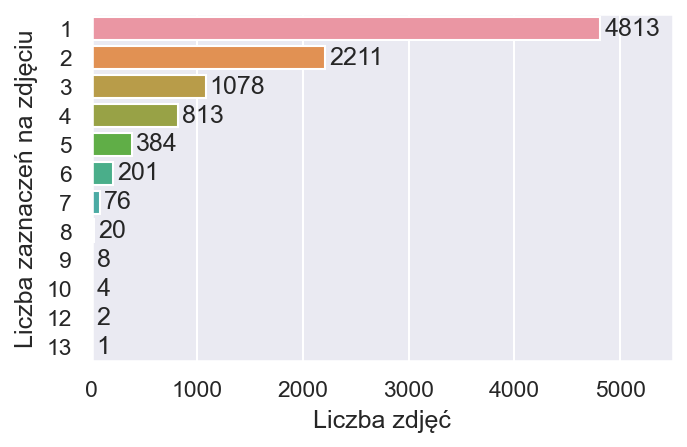

In [246]:
fig, ax = plt.subplots(figsize=(5,3))
sn.countplot(data = x, y='number of selections')
ax.set_ylabel("Liczba zaznaczeń na zdjęciu")
ax.set_xlabel("Liczba zdjęć")
ax.bar_label(ax.containers[0], padding=2)
ax.set_xlim(0,5500)
plt.show()

### Rozkład liczby zaznaczeń na zdjęciach: ok. połowa zdjęc ma jedno zaznaczenie, następnie ćwierć zbioru ma dwa zaznaczenia. Jednak zdarzają się obrazy z większą liczbą zaznaczeń, w szczególności istnieje 7 zdjęć z 10 lub więcej zaznaczeniami.

# Liczba unikalnych kombinacji etykiet na pojedynczym zdjęciu

### W poprzedniej sekcji skupiliśmy uwagę na ogólnej liczbie wszystkich etykiet na zdjęciach, w tej na liczbie tylko unikalnych etykiet.

In [15]:
df_sort = df_description_train.sort_values("class").reset_index()

In [16]:
df_group = df_sort.groupby('filename')
df_image_unique_labels = df_group.apply(lambda x: x['class'].unique())

In [17]:
df_image_unique_labels[0:4]

filename
005298_jpg.rf.bdf672a92632a08c47c53421c5feab17.jpg       [helmet]
005299_jpg.rf.5c375d5c954c5c1a672e667d13265200.jpg       [helmet]
005300_jpg.rf.52796d986dcf99174a1d27305b54f661.jpg    [no_helmet]
005301_jpg.rf.8de3b86398dfba10722ec31009b6f084.jpg    [no_helmet]
dtype: object

In [18]:
df_image_unique_labels = df_image_unique_labels.reset_index()
df_image_unique_labels.columns = ["filename", "unique labels"]
df_image_unique_labels['amount of labels'] = df_image_unique_labels['unique labels'].str.len()

In [19]:
df_image_unique_labels

filename  \
0     005298_jpg.rf.bdf672a92632a08c47c53421c5feab17...   
1     005299_jpg.rf.5c375d5c954c5c1a672e667d13265200...   
2     005300_jpg.rf.52796d986dcf99174a1d27305b54f661...   
3     005301_jpg.rf.8de3b86398dfba10722ec31009b6f084...   
4     005303_jpg.rf.05c9619ce3ca9ba0e17cdb7050bb512b...   
...                                                 ...   
9606  packing993_jpg.rf.5c9816afb38473cba75aba011518...   
9607  packing995_jpg.rf.5d0460faefc88b04d45dc83b3d76...   
9608  packing998_jpg.rf.e870d670e12ca1529e11baf7d5bb...   
9609  packing99_jpg.rf.7959b5b58bb56b71dae8c9391211a...   
9610  packing9_jpg.rf.31516452db900146232cbca80d19c4...   

              unique labels  amount of labels  
0                  [helmet]                 1  
1                  [helmet]                 1  
2               [no_helmet]                 1  
3               [no_helmet]                 1  
4                  [helmet]                 1  
...                     ...               ...  
9606              [goggles]                 1  
9607              [goggles]                 1  
9608              [goggles]                 1  
9609              [goggles]                 1  
9610  [goggles, no_goggles]                 2  

[9611 rows x 3 columns]

# Liczba unikatowych zdjęć w zbiorze danych

In [250]:
len(df_image_unique_labels)

9611

# Liczba unikatowych zaznaczeń

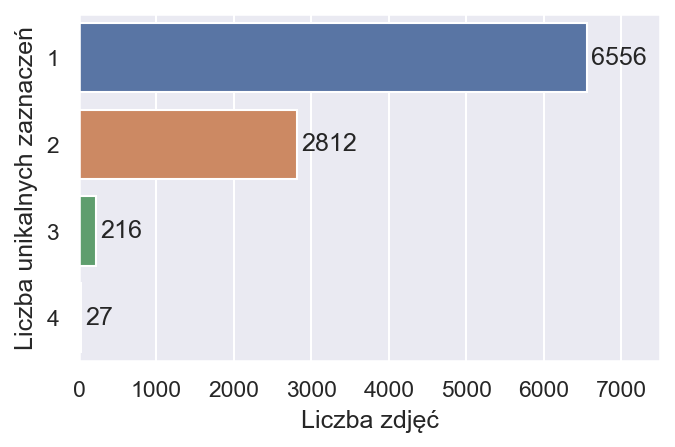

In [247]:
fig, ax = plt.subplots(figsize=(5,3))
sn.countplot(data = df_image_unique_labels, y='amount of labels')
ax.set_ylabel("Liczba unikalnych zaznaczeń")
ax.set_xlabel("Liczba zdjęć")
ax.bar_label(ax.containers[0], padding=2)
ax.set_xlim(0,7500)
plt.show()

### Widzimy, że na większości zdjęć widnieje tylko jedna unikalna etykieta.

# Liczba różnych kombinacji unikalnych etykiet na pojedynczym zdjęciu

In [21]:
len([*map(list,df_image_unique_labels["unique labels"].map(tuple).unique())])

58

In [22]:
df_image_unique_labels["New"] = df_image_unique_labels["unique labels"].apply(lambda x: ",".join(x))

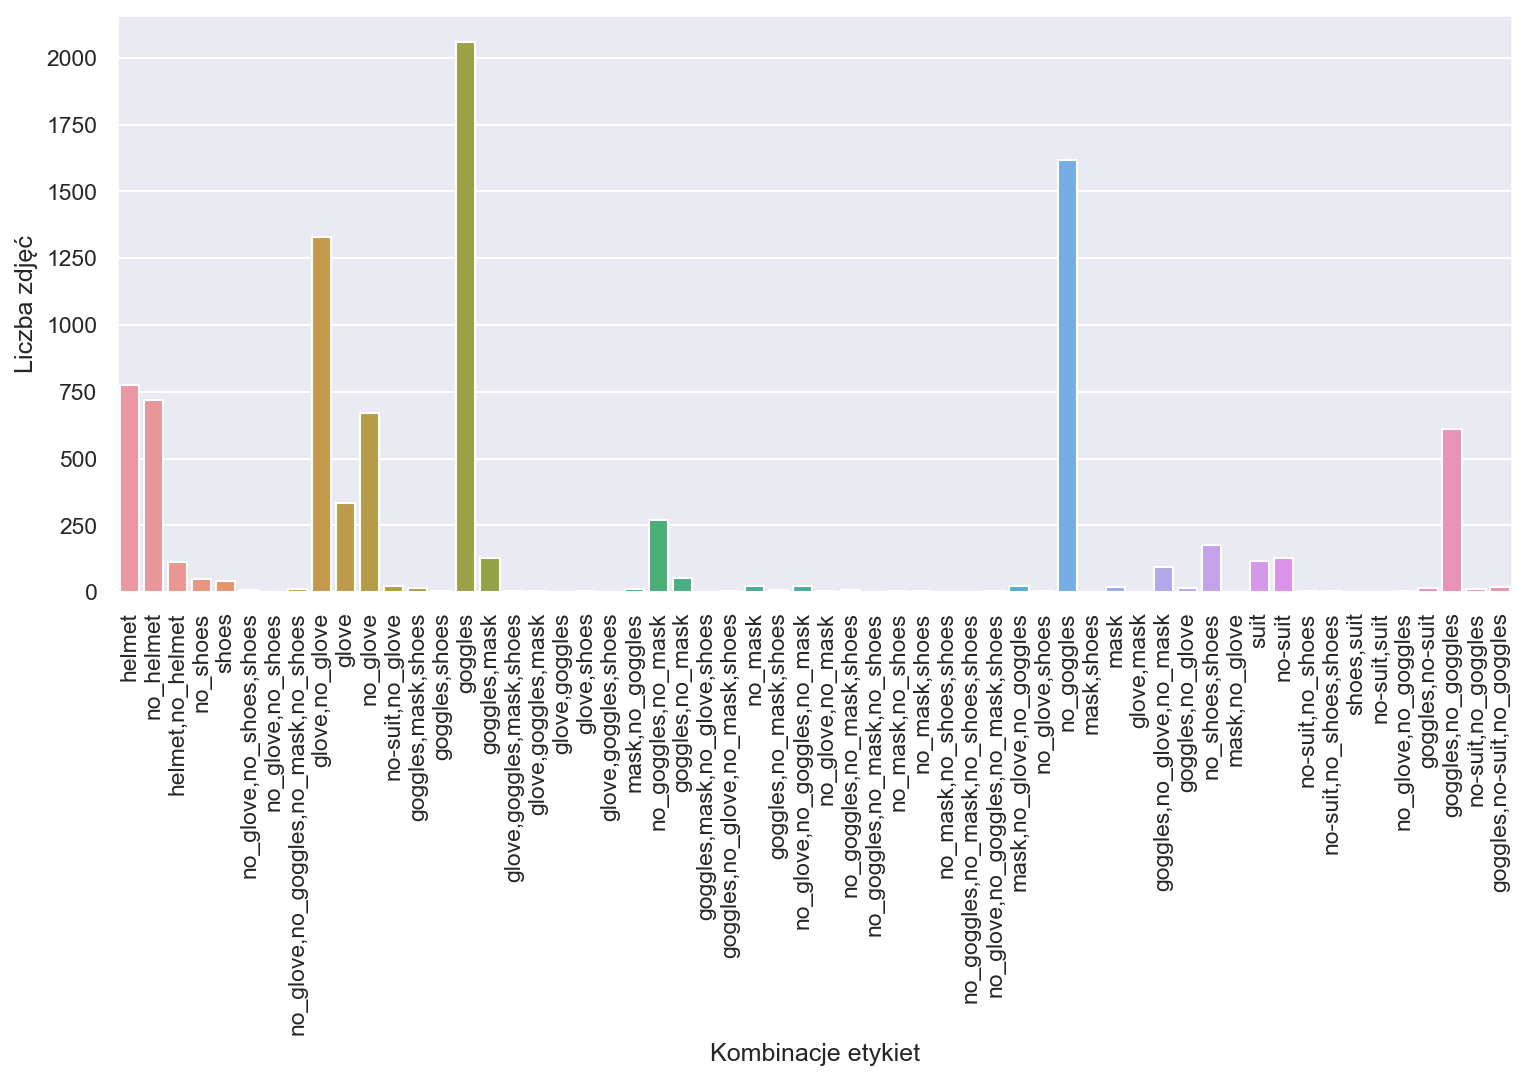

In [23]:
fig, ax = plt.subplots(figsize=(12,5))
sn.countplot(data = df_image_unique_labels, x='New')
ax.set_ylabel("Liczba zdjęć")
ax.set_xlabel("Kombinacje etykiet")
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
plt.show()

# Rozmiar zdjęć

In [24]:
df_description_train["resolution"] = df_description_train["width"].astype(str) + "x" + df_description_train["height"].astype(str) 

In [132]:
#tworzymy zbiór danych zawierający "unikalne" zdjęcia, ich szerokość, wysokość i rozdzielczość
df_image_train = df_description_train[["filename", "resolution", "width", "height"]].drop_duplicates().reset_index()

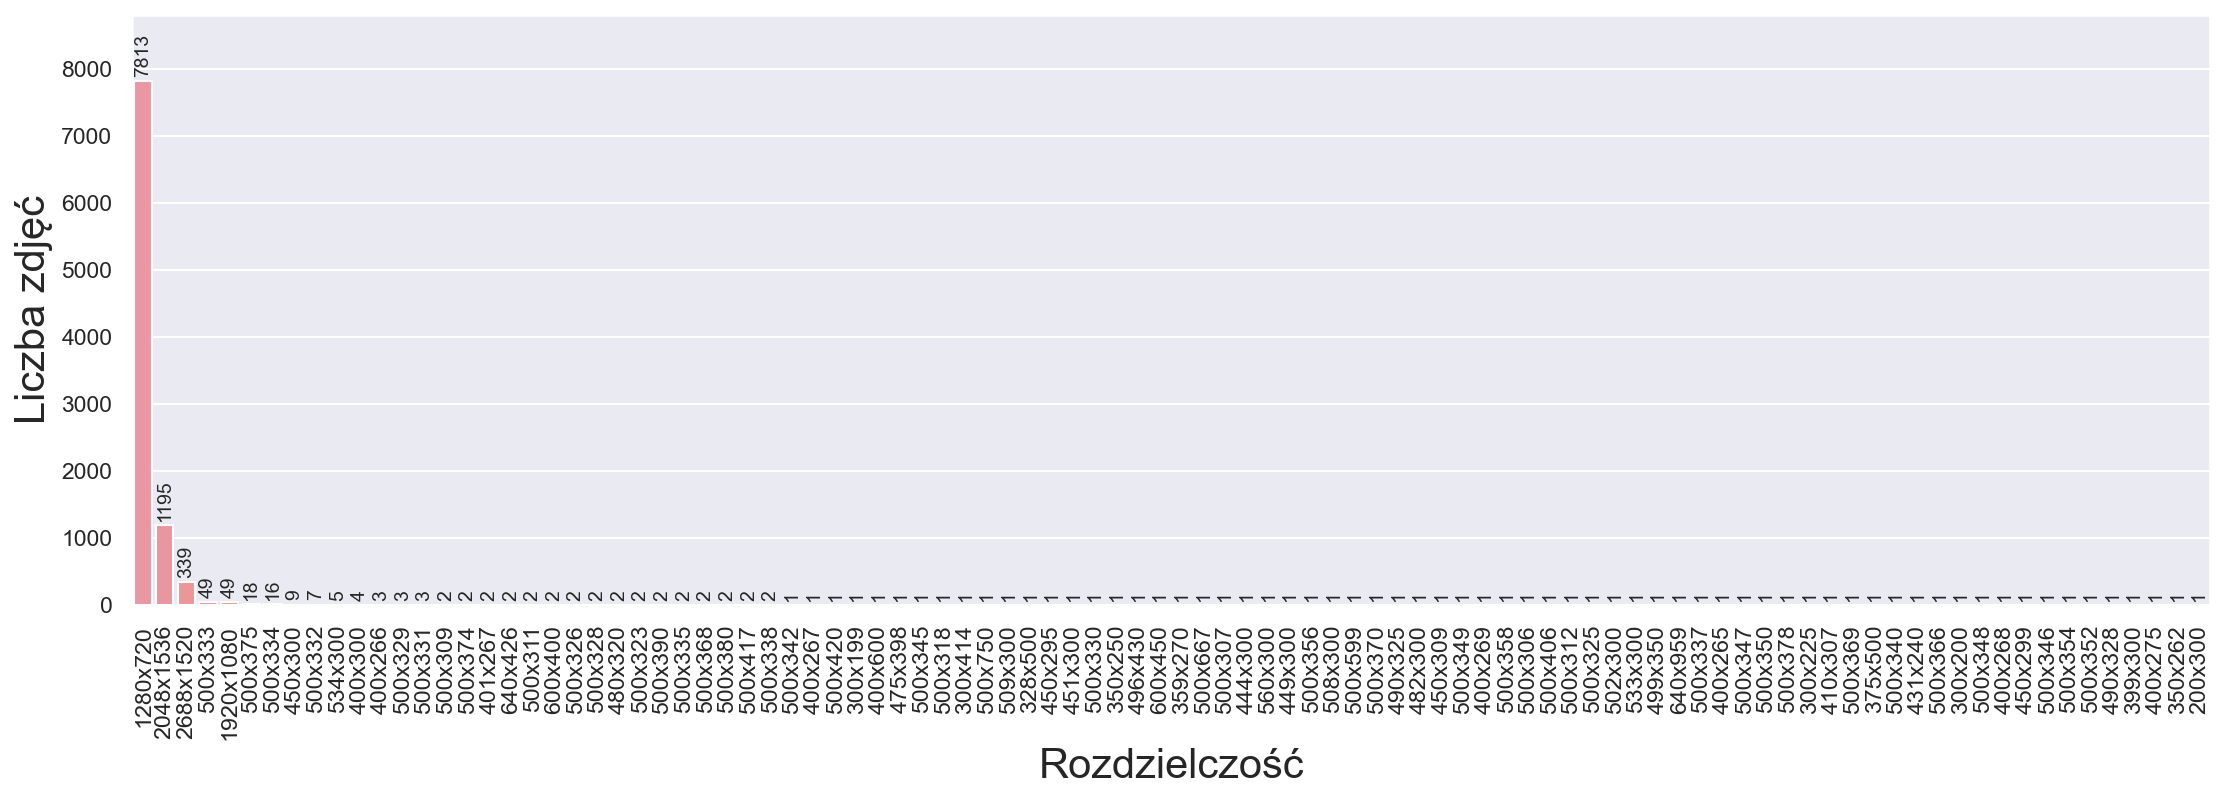

In [248]:
sn.set()
fig, ax = plt.subplots(figsize=(15,5.5))
sn.countplot(data = df_image_train, x="resolution", order =  df_image_train["resolution"].value_counts().index)
ax.set_ylabel("Liczba zdjęć", fontsize=20)
ax.set_xlabel("Rozdzielczość", fontsize=20)
ax.set_ylim(0,8800)
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90, fontsize=11.1)
ax.bar_label(ax.containers[0], padding=2, fontsize=9.3, rotation=90)
fig.tight_layout()
plt.show()

### Widzimy, że zdecydowana większość zdjęć jest w rozdzielczości 1280 x 720. Następnie jest rozdzielczość 2048x1536 z ok .1200 zdjęciami i 2688x1620 z ok. 340 zdjęciami. Reszta rozdzielczości występuje dużo rzadziej, a czego większość z nich jest dużo mniejsza od wcześniej wymienionych. Po pierwsze, trzeba zająć się przeskalowaniem zdjęć do jednej rozdzielczości, a po drugie warto przynajmniej przemyśleć czy nie warto byłoby zostawić np. tylko 3 najczęściej występujących rozdzielczości, które obejmują ponad 95% całości zbioru danych.

# Rozkłady szerokości i wysokości zdjęć oczywiście są bardzo mocno skorelowane z tym rozdzielczości, jednakże poniżej przedstawione zostały histogramy dla obu tych parametrów.

# Szerokość zdjęcia

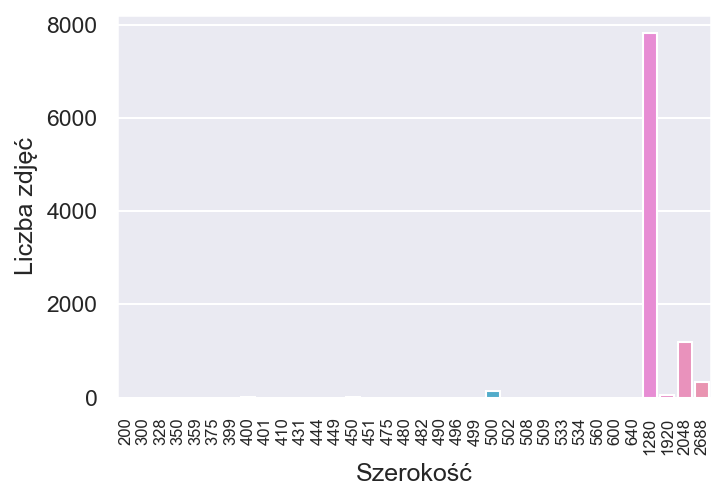

In [263]:
fig, ax = plt.subplots(figsize=(5,3.5))
sn.countplot(data = df_image_train, x="width")
ax.set_ylabel("Liczba zdjęć")
ax.set_xlabel("Szerokość")
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90, fontsize=8)
fig.tight_layout()
plt.show()

# Wysokość zdjęcia

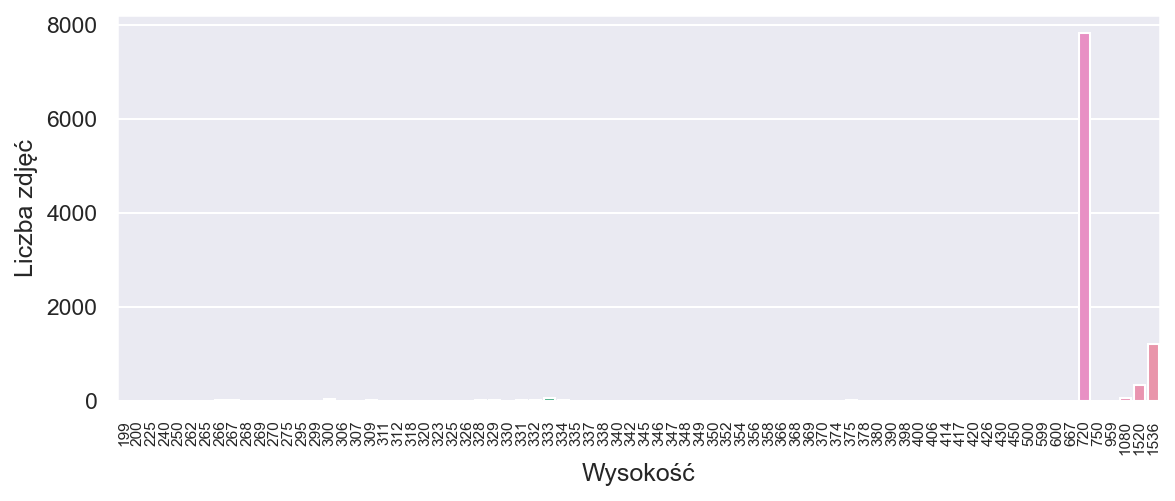

In [259]:
sn.set()
fig, ax = plt.subplots(figsize=(8,3.5))
sn.countplot(data = df_image_train, x="height")
ax.set_ylabel("Liczba zdjęć")
ax.set_xlabel("Wysokość")
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90, fontsize=7.4)
fig.tight_layout()
plt.show()

# Wielkość zaznaczeń

In [299]:
df_description_train["selection width"] = df_description_train["xmax"] - df_description_train["xmin"]
df_description_train["selection height"] = df_description_train["ymax"] - df_description_train["ymin"]
df_description_train["selection size in pixels"] = df_description_train["selection width"] * df_description_train["selection height"]


In [310]:
df_description_train["image size in pixels"] = df_description_train["width"] * df_description_train["height"]


In [311]:
df_description_train.head()

filename  width  height  \
0  kp1737_jpg.rf.78a83ac82adaa308fa023354c4d091a4...   1280     720   
1  packing1020_jpg.rf.7949b2c00e93d76df0fe29034dc...   1280     720   
2  packing1020_jpg.rf.7949b2c00e93d76df0fe29034dc...   1280     720   
3  packing1020_jpg.rf.7949b2c00e93d76df0fe29034dc...   1280     720   
4  img273_jpg.rf.78e6836c24c899b455bb6079eb65ae34...   1280     720   

        class  xmin  ymin  xmax  ymax resolution  selection width  \
0  no_goggles   509   541   582   576   1280x720               73   
1  no_goggles   934   246  1003   279   1280x720               69   
2  no_goggles   183   249   239   278   1280x720               56   
3  no_goggles   840   469   966   519   1280x720              126   
4       glove   153   314   307   427   1280x720              154   

   selection height  selection size in pixels  selection width standarized  \
0                35                      2555                     0.057031   
1                33                      2277                     0.053906   
2                29                      1624                     0.043750   
3                50                      6300                     0.098437   
4               113                     17402                     0.120313   

   selection height standarized  image size in pixels  
0                      0.048611                921600  
1                      0.045833                921600  
2                      0.040278                921600  
3                      0.069444                921600  
4                      0.156944                921600

# Wielkość zaznaczeń (w liczbie pikseli)

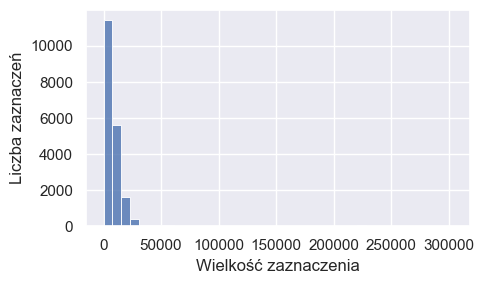

In [319]:
fig, ax = plt.subplots(figsize=(5,3))
sn.histplot(df_description_train["selection size in pixels"], alpha=0.8, bins=40)
ax.set_xlabel("Wielkość zaznaczenia")
ax.set_ylabel("Liczba zaznaczeń")
fig.tight_layout()
plt.show()

## Tylko zaznaczenia mniejsze od 40000 pikseli

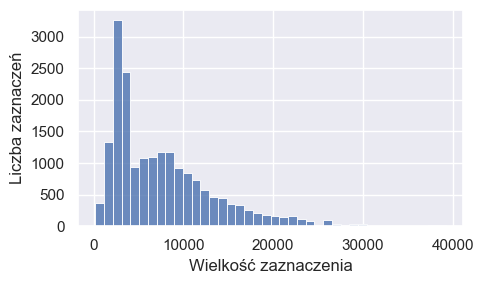

In [318]:
fig, ax = plt.subplots(figsize=(5,3))
sn.histplot(df_description_train[df_description_train["selection size in pixels"]<40000].loc[:,"selection size in pixels"], 
            alpha=0.8, bins=40)
ax.set_xlabel("Wielkość zaznaczenia")
ax.set_ylabel("Liczba zaznaczeń")
fig.tight_layout()
plt.show()

## Wielkość zaznaczenia/wielkość całego zdjęcia

In [323]:
df_description_train["relative size of selection"] = df_description_train["selection size in pixels"] / df_description_train["image size in pixels"]

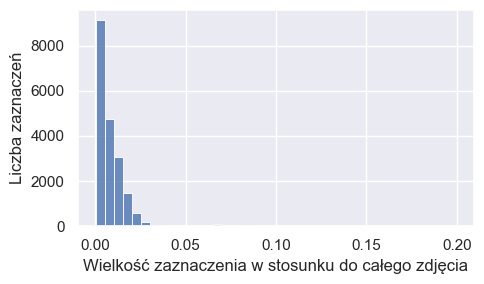

In [324]:
sn.set()
fig, ax = plt.subplots(figsize=(5,3))
sn.histplot(df_description_train["relative size of selection"], 
            alpha=0.8, bins=40)
ax.set_xlabel("Wielkość zaznaczenia w stosunku do całego zdjęcia")
ax.set_ylabel("Liczba zaznaczeń")
fig.tight_layout()
plt.show()

## Wartości mniejsze od 0.05

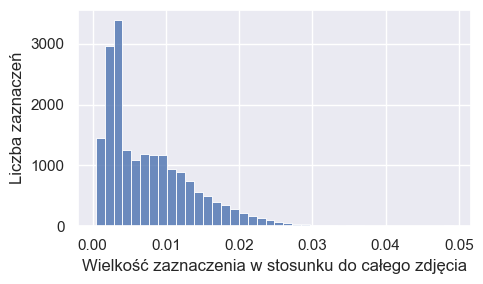

In [328]:
sn.set()
fig, ax = plt.subplots(figsize=(5,3))
sn.histplot(df_description_train[df_description_train["relative size of selection"]<0.05].loc[:,"relative size of selection"], 
            alpha=0.8, bins=40)
ax.set_xlabel("Wielkość zaznaczenia w stosunku do całego zdjęcia")
ax.set_ylabel("Liczba zaznaczeń")
fig.tight_layout()
plt.show()

### Widzimy, że rozkład wielkości zaznaczeń w pikselach również jest nierównomierny. Zdecydowana większość zaznaczeń zajmuje mniej niż 3% całkowitej powierzchni zdjęcia.

# Szerokość zaznaczeń

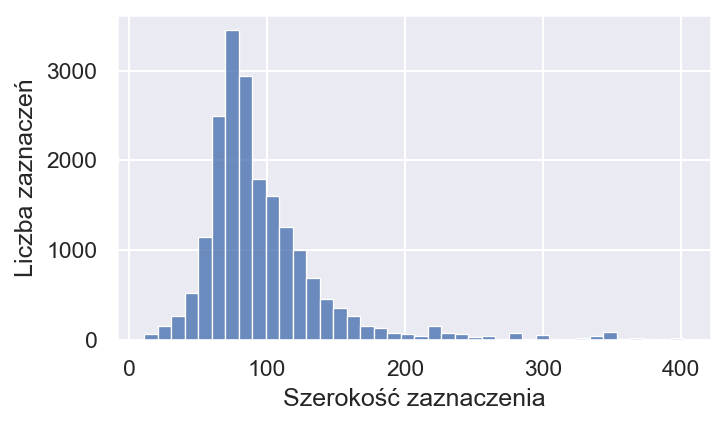

In [267]:
fig, ax = plt.subplots(figsize=(5,3))
sn.histplot(df_description_train["selection width"], alpha=0.8, bins=40)
ax.set_xlabel("Szerokość zaznaczenia")
ax.set_ylabel("Liczba zaznaczeń")
fig.tight_layout()
plt.show()

# Szerokość zaznaczeń ze względu na kategorię

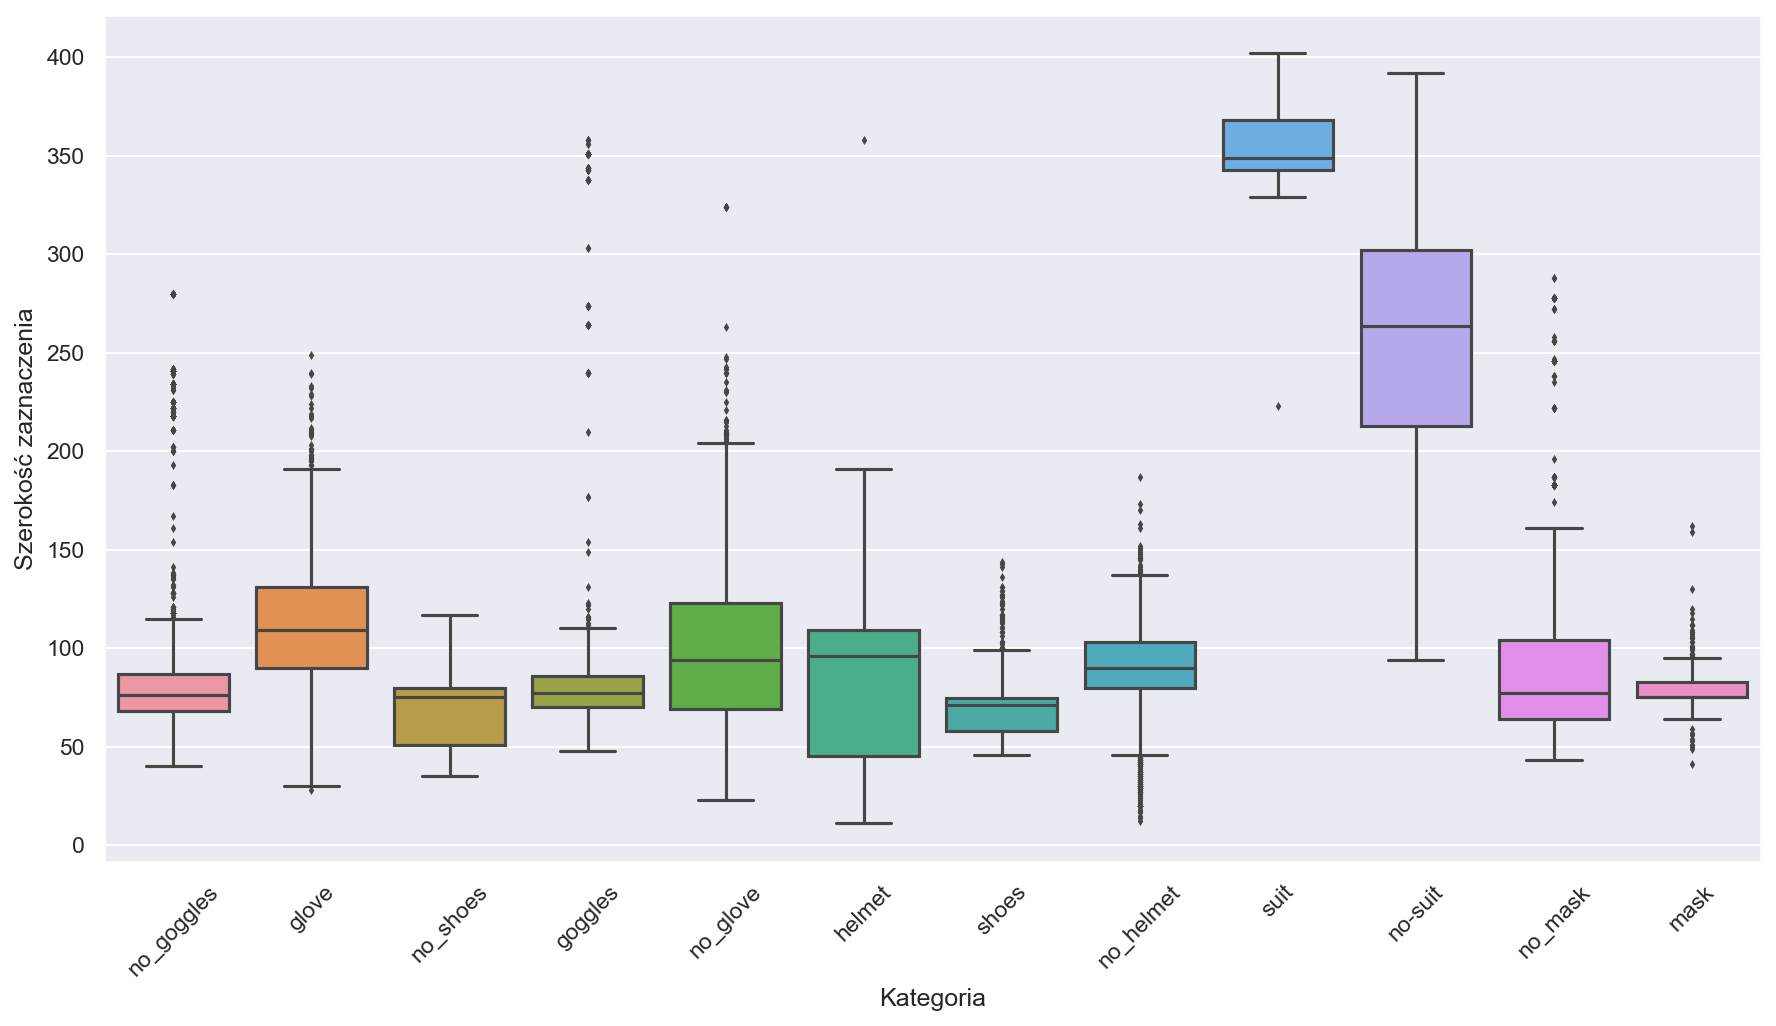

In [266]:
sn.set()
fig, ax = plt.subplots(figsize=(12,7))
sn.boxplot(data=df_description_train, y="selection width", x="class", fliersize=1.7)
ax.set_ylabel("Szerokość zaznaczenia")
ax.set_xlabel("Kategoria")
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45)
fig.tight_layout()
plt.show()

### Ze względu na to, że zdjęcia mają różne szerokości, ważne też się przyjrzeć nie samej szerokości zaznaczenia, ale też jaki procent stanowi ona z szerokości całego zdjęcia

# Znormalizowana szerokość zaznaczeń ze względu na kategorię

In [32]:
df_description_train["selection width standarized"] = df_description_train["selection width"] / df_description_train["width"] 
df_description_train["selection height standarized"] = df_description_train["selection height"] / df_description_train["height"] 

In [33]:
df_description_train.head()

filename  width  height  \
0  kp1737_jpg.rf.78a83ac82adaa308fa023354c4d091a4...   1280     720   
1  packing1020_jpg.rf.7949b2c00e93d76df0fe29034dc...   1280     720   
2  packing1020_jpg.rf.7949b2c00e93d76df0fe29034dc...   1280     720   
3  packing1020_jpg.rf.7949b2c00e93d76df0fe29034dc...   1280     720   
4  img273_jpg.rf.78e6836c24c899b455bb6079eb65ae34...   1280     720   

        class  xmin  ymin  xmax  ymax resolution  selection width  \
0  no_goggles   509   541   582   576   1280x720               73   
1  no_goggles   934   246  1003   279   1280x720               69   
2  no_goggles   183   249   239   278   1280x720               56   
3  no_goggles   840   469   966   519   1280x720              126   
4       glove   153   314   307   427   1280x720              154   

   selection height  selection size in pixels  selection width standarized  \
0                35                    921600                     0.057031   
1                33                    921600                     0.053906   
2                29                    921600                     0.043750   
3                50                    921600                     0.098437   
4               113                    921600                     0.120313   

   selection height standarized  
0                      0.048611  
1                      0.045833  
2                      0.040278  
3                      0.069444  
4                      0.156944

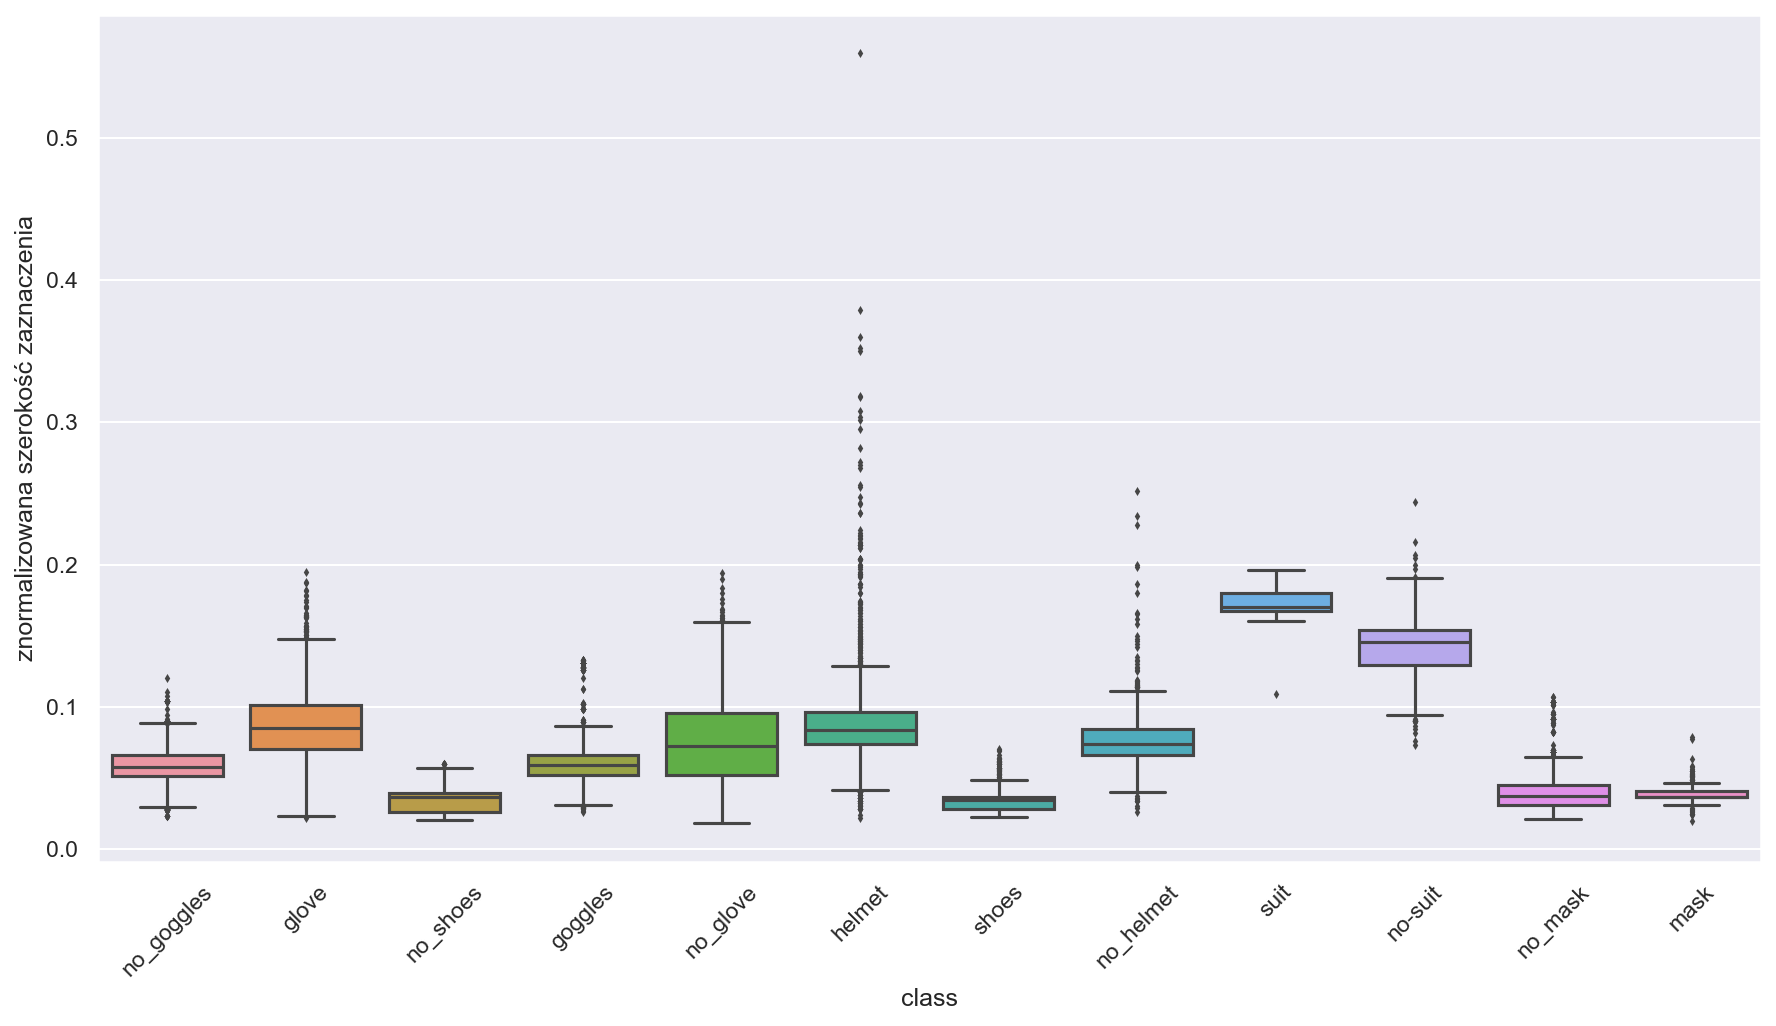

In [268]:
sn.set()
fig, ax = plt.subplots(figsize=(12,7))
sn.boxplot(data=df_description_train, y="selection width standarized", x="class", fliersize=1.7)
ax.set_ylabel("znormalizowana szerokość zaznaczenia")
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45)
fig.tight_layout()
plt.show()

### Sprawdzenie kilku wartości odstających. Bierzemy pierwsze w kolejności procentowej szerokości zaznaczenia z etykietkami: 'no_goggles', 'goggles', 'no_glove', 'glove', 'no_mask', 'mask', 'helmet'

In [35]:
x = df_description_train.loc[df_description_train['class'] == 'helmet']

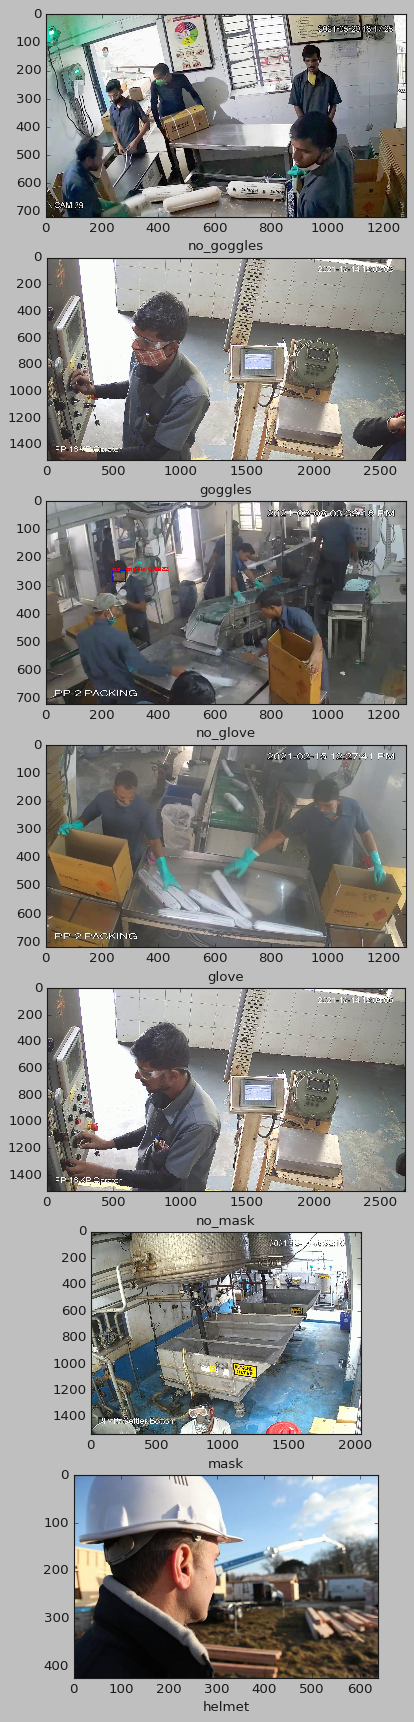

In [36]:
ROOT_PATH = 'C:/Data Science/Projekty/Surveily zadanie/PPEs-4/train/'
plt.style.use('classic')
fig, ax = plt.subplots(7, figsize=(14,26))
i = 0
for label in ["no_goggles", "goggles", "no_glove", "glove", "no_mask", "mask", "helmet"]:
    x = df_description_train.loc[df_description_train['class'] == label]
    x = x["filename"].loc[df_description_train['selection width standarized'] == x['selection width standarized'].max()].reset_index()
    image_name = x['filename'].loc[0]
    test_image = skimage.io.imread(ROOT_PATH+image_name)
    ax[i].imshow(test_image)
    ax[i].set_xlabel(label)
    
    i+=1
plt.show()

### Z powyższych zdjęć warto zwrócić uwagę na zdjęcie z kategorią "no_glove", na którym zaznaczony na niebiesko jest bounding box wraz z czerownym podpisem "no mask" i jakąś liczbą. Na pewno można uznać to za pewne zaburzenie w obrazie.

# Znormalizowana wysokość

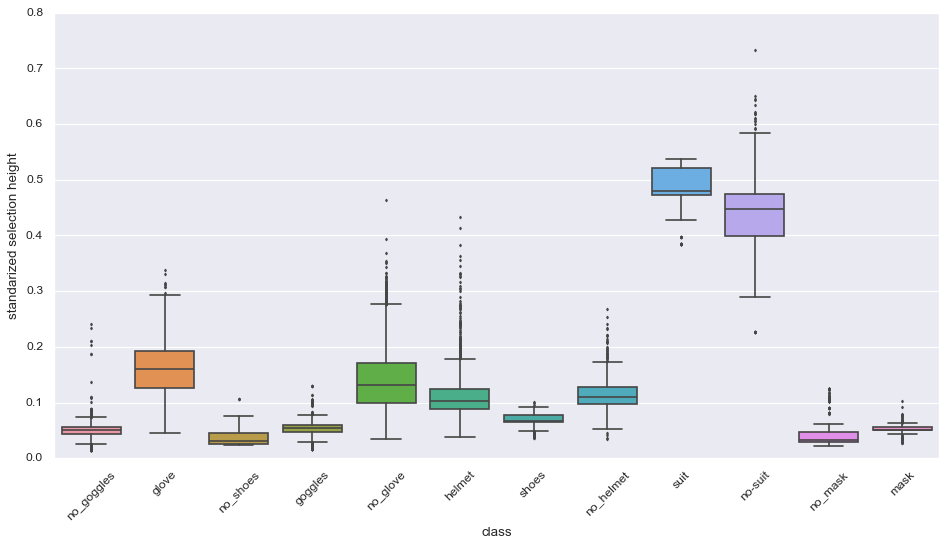

In [37]:
sn.set()
fig, ax = plt.subplots(figsize=(12,7))
sn.boxplot(data=df_description_train, y="selection height standarized", x="class", fliersize=1.7)
ax.set_ylabel("standarized selection height")
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45)
fig.tight_layout()
plt.show()

# Sprawdzenie wartości odstających - znormalizowana wysokość zaznaczenia

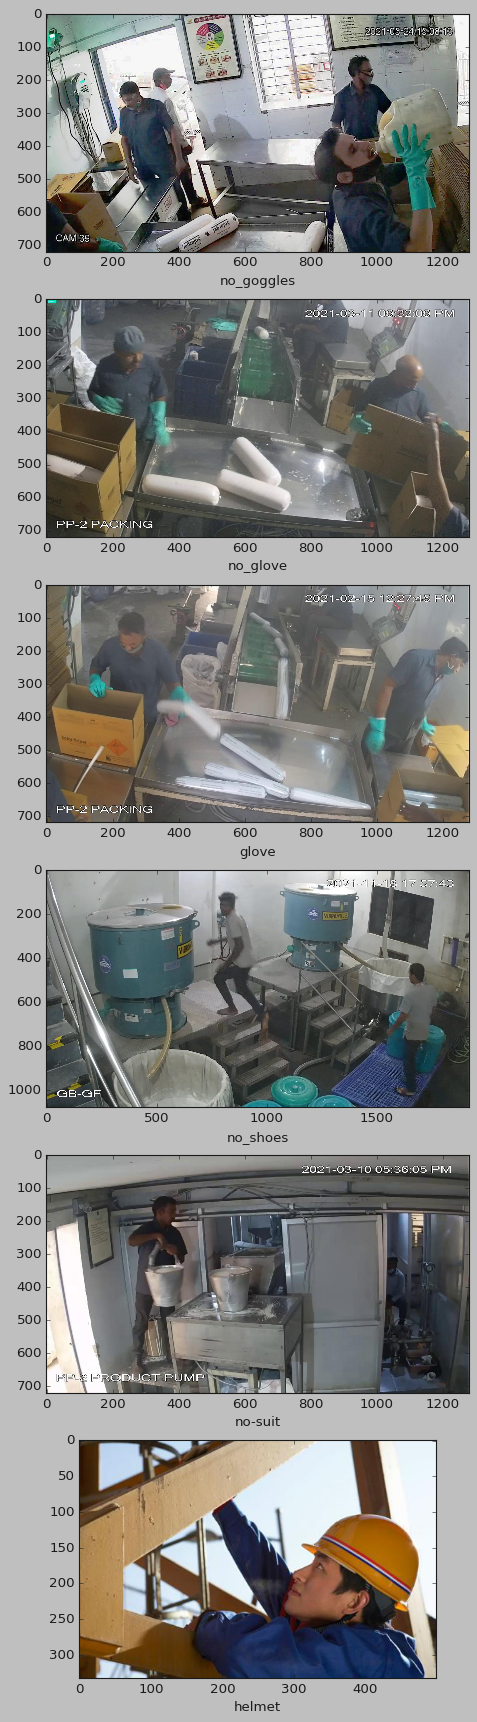

In [38]:
ROOT_PATH = 'C:/Data Science/Projekty/Surveily zadanie/PPEs-4/train/'
plt.style.use('classic')
fig, ax = plt.subplots(6, figsize=(14,26))
i = 0
for label in ["no_goggles", "no_glove", "glove", "no_shoes", "no-suit", "helmet"]:
    x = df_description_train.loc[df_description_train['class'] == label]
    x = x["filename"].loc[df_description_train['selection height standarized'] == x['selection height standarized'].max()].reset_index()
    image_name = x['filename'].loc[0]
    test_image = skimage.io.imread(ROOT_PATH+image_name)
    ax[i].imshow(test_image)
    ax[i].set_xlabel(label)
    
    i+=1
plt.show()

# Jasność obrazów, kanały rgb

Przykład:
Uśrednione nasycenie koloru czerwonego w pierwszym obrazie:  0.2967
Uśrednione nasycenie koloru zielonego w pierwszym obrazie:  0.2457
Uśrednione nasycenie koloru niebieskiego w pierwszym obrazie:  0.2337
Uśredniona jasność pierwszego obrazu:  0.2597
Uśrednione nasycenie koloru czerwonego w drugim obrazie:  0.6551
Uśrednione nasycenie koloru zielonego w drugim obrazie:  0.6367
Uśrednione nasycenie koloru niebieskiego w drugim obrazie:  0.6207
Uśredniona jasność drugiego obrazu:  0.6404


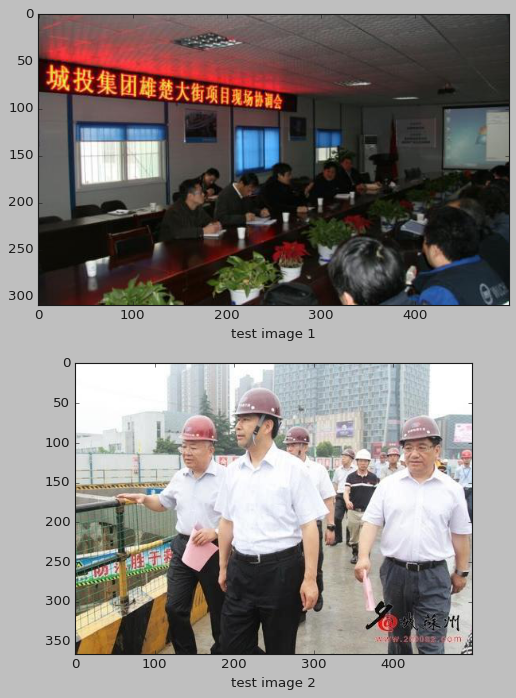

In [39]:
print("Przykład:")

fig, ax = plt.subplots(2, figsize=(10,10))
image_name = '005379_jpg.rf.efcf1f5f029f22f898d018a943ad15cd.jpg'
test_image = skimage.io.imread(ROOT_PATH+image_name)  # skimage.io.imread returns RGB in default
ax[0].imshow(test_image)
ax[0].set_xlabel("test image 1")
gray_test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
gray_test_image = gray_test_image/256   #znormalizowanie pikseli z zakresu 0-256 do 0-1
avg_brightness = round(np.mean(gray_test_image),4)
red_mean = round(np.mean(test_image[:, :, 0])/256, 4)
green_mean = round(np.mean(test_image[:, :, 1])/256, 4)
blue_mean = round(np.mean(test_image[:, :, 2])/256, 4)

print("Uśrednione nasycenie koloru czerwonego w pierwszym obrazie: ", red_mean)
print("Uśrednione nasycenie koloru zielonego w pierwszym obrazie: ", green_mean)
print("Uśrednione nasycenie koloru niebieskiego w pierwszym obrazie: ", blue_mean)
print("Uśredniona jasność pierwszego obrazu: ", avg_brightness)

image_name = '005432_jpg.rf.255f57aa8d4b801e762af294e6f853f6.jpg'
test_image = skimage.io.imread(ROOT_PATH+image_name)
ax[1].imshow(test_image)
ax[1].set_xlabel("test image 2")
gray_test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
gray_test_image = gray_test_image/256    #znormalizowanie pikseli z zakresu 0-256 do 0-1
avg_brightness = round(np.mean(gray_test_image),4)
red_mean = round(np.mean(test_image[:, :, 0])/256, 4)
green_mean = round(np.mean(test_image[:, :, 1])/256, 4)
blue_mean = round(np.mean(test_image[:, :, 2])/256, 4)
print("Uśrednione nasycenie koloru czerwonego w drugim obrazie: ", red_mean)
print("Uśrednione nasycenie koloru zielonego w drugim obrazie: ", green_mean)
print("Uśrednione nasycenie koloru niebieskiego w drugim obrazie: ", blue_mean)

print("Uśredniona jasność drugiego obrazu: ", avg_brightness)
plt.show()

# Średnia jasność, oraz nasycenie kolorów RGB

In [95]:
all_files = os.listdir(ROOT_PATH)  #wszystkie pliki z naszego folderu
jpg_files = [f for f in all_files if f.lower().endswith('.jpg')]

In [96]:
i = 0

avg_brightness = []
avg_red_list = []
avg_blue_list = []
avg_green_list = []

filenames_list = []
for image_name in jpg_files:
    filenames_list.append(image_name)
    # full path to image
    img_path = os.path.join(ROOT_PATH, image_name)

    # Read the image using skimage.io.imread
    image = skimage.io.imread(img_path)
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_image = gray_image/256    #znormalizowanie pikseli z zakresu 0-256 do 0-1
    avg_brightness.append(round(np.mean(gray_image),4))
    avg_red_list.append(round(np.mean(image[:, :, 0])/256, 4))
    avg_green_list.append(round(np.mean(image[:, :, 1])/256, 4))
    avg_blue_list.append(round(np.mean(image[:, :, 2])/256, 4))
    
    
    i += 1
    if i % 1000 == 0:
        print("loop iteration:", i)

loop iteration: 1000
loop iteration: 2000
loop iteration: 3000
loop iteration: 4000
loop iteration: 5000
loop iteration: 6000
loop iteration: 7000
loop iteration: 8000
loop iteration: 9000


In [97]:
df_colors = pd.DataFrame(list(zip(filenames_list, avg_brightness, avg_red_list, avg_green_list, avg_blue_list)),
            columns=["filename", "avg_brightness", "avg_red", "avg_green", "avg_blue"])

In [104]:
df_colors.head()

filename  avg_brightness  avg_red  \
0  005298_jpg.rf.bdf672a92632a08c47c53421c5feab17...          0.4788   0.4807   
1  005299_jpg.rf.5c375d5c954c5c1a672e667d13265200...          0.3001   0.2957   
2  005300_jpg.rf.52796d986dcf99174a1d27305b54f661...          0.5579   0.5481   
3  005301_jpg.rf.8de3b86398dfba10722ec31009b6f084...          0.3554   0.3741   
4  005303_jpg.rf.05c9619ce3ca9ba0e17cdb7050bb512b...          0.5205   0.5458   

   avg_green  avg_blue  
0     0.4921    0.4049  
1     0.3111    0.2553  
2     0.5571    0.5880  
3     0.3512    0.3278  
4     0.5177    0.4698

In [663]:
pd.melt(df_colors)[pd.melt(df_colors)["variable"]!="filename"].reset_index(drop=True)

variable   value
0      avg_brightness  0.4788
1      avg_brightness  0.3001
2      avg_brightness  0.5579
3      avg_brightness  0.3554
4      avg_brightness  0.5205
...               ...     ...
38439        avg_blue  0.5262
38440        avg_blue  0.5269
38441        avg_blue  0.5156
38442        avg_blue  0.5333
38443        avg_blue  0.5442

[38444 rows x 2 columns]

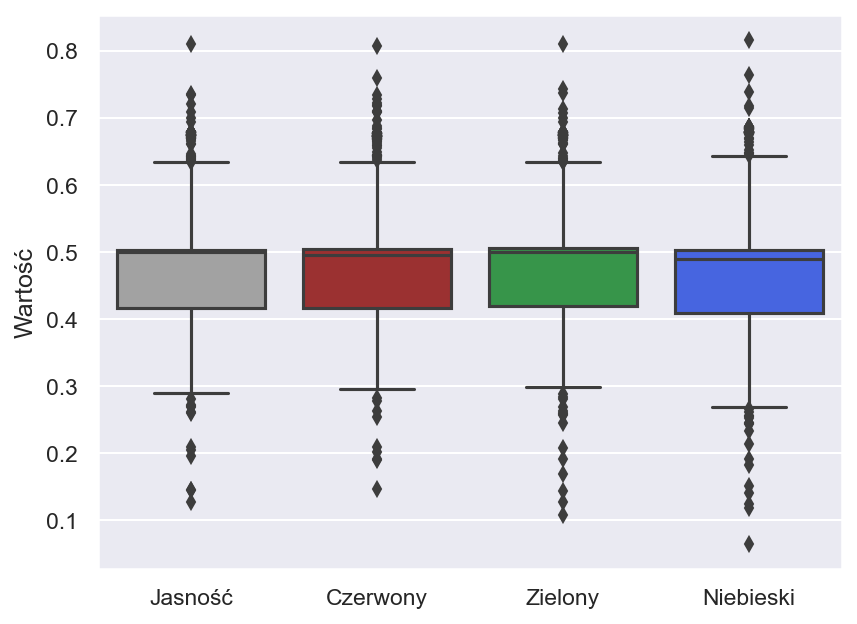

In [280]:
sn.set()
fig, ax = plt.subplots()
sn.boxplot(data=pd.melt(df_colors)[pd.melt(df_colors)["variable"]!="filename"].reset_index(drop=True),
           x="variable", y="value", palette=["#A2A2A2", "#AD1F1F", "#27A540", "#2E56F9"])
ax.set_xticks(ticks=[0,1,2,3], labels=["Jasność", "Czerwony", "Zielony", "Niebieski"])
ax.set_xlabel("")
ax.set_ylabel("Wartość")
plt.show()

### Widzimy, że połowa zdjęć (tzn. ta z IQR) znajduje się w wąskim przedziale średniej jasności między 0.4, a 0.5. Wydaje się, że zbiór danych nie zawiera bardzo zróżnicowanych zdjęć pod względem jasności i powinno się zastanowić czy zbiór treningowy dobrze odzwierciedla rzeczywiste sytuacje

# Sprawdzenie najjaśniejszego i najciemniejszego obrazu

In [ ]:
#df_description_train = pd.merge(df_description_train,df_colors, on='filename')

In [688]:
#najjaśniejszy obraz
x = df_colors[df_colors["avg_brightness"] == df_colors["avg_brightness"].max()]
image_name = x["filename"].item()
test_image = skimage.io.imread(ROOT_PATH+image_name)

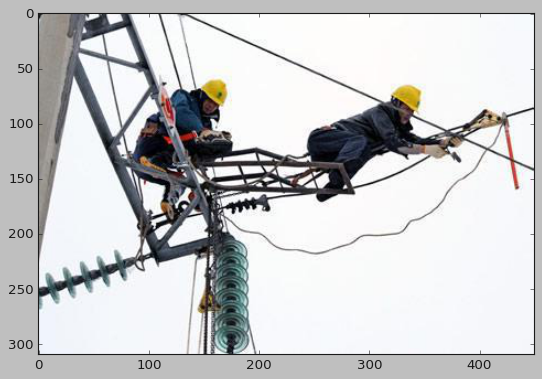

In [689]:
plt.style.use("classic")
plt.imshow(test_image)

In [690]:
#najciemniejszy obraz
x = df_colors[df_colors["avg_brightness"] == df_colors["avg_brightness"].min()]
image_name = x["filename"].item()
test_image = skimage.io.imread(ROOT_PATH+image_name)

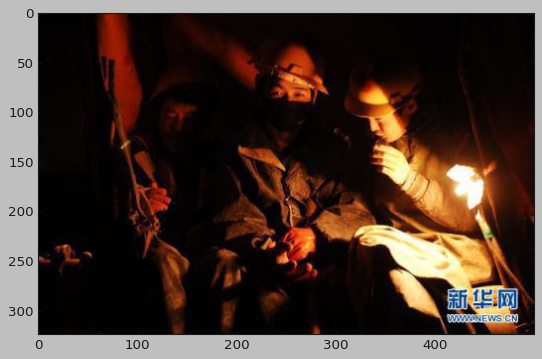

In [691]:
plt.style.use("classic")
plt.imshow(test_image)

# Rozmieszczenie zaznaczeń

In [714]:
df_description_train.head()

filename  width  height  \
0  kp1737_jpg.rf.78a83ac82adaa308fa023354c4d091a4...   1280     720   
1  packing1020_jpg.rf.7949b2c00e93d76df0fe29034dc...   1280     720   
2  packing1020_jpg.rf.7949b2c00e93d76df0fe29034dc...   1280     720   
3  packing1020_jpg.rf.7949b2c00e93d76df0fe29034dc...   1280     720   
4  img273_jpg.rf.78e6836c24c899b455bb6079eb65ae34...   1280     720   

        class  xmin  ymin  xmax  ymax  selection width  selection height  \
0  no_goggles   509   541   582   576               73                35   
1  no_goggles   934   246  1003   279               69                33   
2  no_goggles   183   249   239   278               56                29   
3  no_goggles   840   469   966   519              126                50   
4       glove   153   314   307   427              154               113   

   selection size in pixels width & height  selection width standarized  \
0                    921600       1280x720                     0.057031   
1                    921600       1280x720                     0.053906   
2                    921600       1280x720                     0.043750   
3                    921600       1280x720                     0.098437   
4                    921600       1280x720                     0.120313   

   selection height standarized  avg_brightness  avg_red  avg_green  avg_blue  
0                      0.048611          0.4942   0.4898     0.4927    0.5142  
1                      0.045833          0.5019   0.5067     0.5017    0.4903  
2                      0.040278          0.5019   0.5067     0.5017    0.4903  
3                      0.069444          0.5019   0.5067     0.5017    0.4903  
4                      0.156944          0.4352   0.4385     0.4366    0.4194

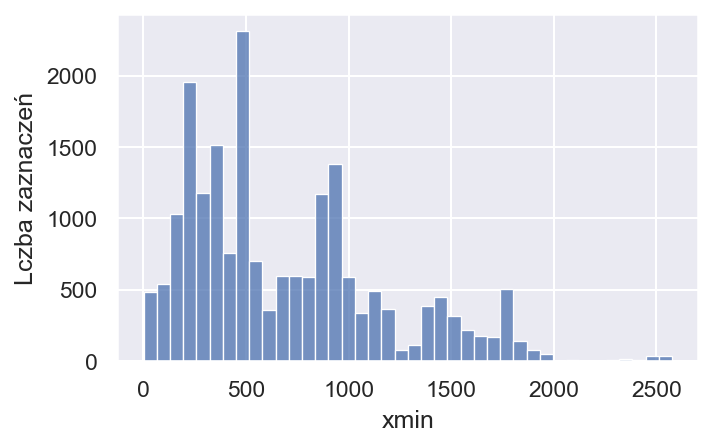

In [283]:
fig, ax = plt.subplots(figsize=(5,3))
sn.histplot(data = df_description_train, x="xmin", bins=40)
ax.set_ylabel("Lczba zaznaczeń")
ax.set_xlabel("xmin")
plt.show()

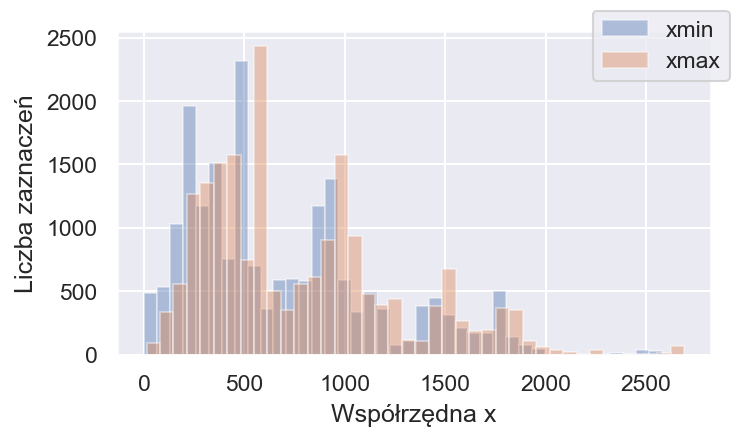

In [281]:
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(df_description_train["xmin"], alpha=0.4, bins=40)
ax.hist(df_description_train["xmax"], alpha=0.4, bins=40)
ax.set_ylabel("Liczba zaznaczeń")
ax.set_xlabel("Współrzędna x")
fig.legend(["xmin", "xmax"], loc="upper right")
fig.tight_layout()
plt.show()

## Szukanie podobieństw między obrazami

In [285]:
image_name = 'kp1042_jpg.rf.d6a2ad254347b6338c39243336adee87.jpg'
test_image_1 = skimage.io.imread(ROOT_PATH+image_name)
image_name = 'kp1045_jpg.rf.e0941394c90ea08f294e4370e936d158.jpg'
test_image_2 = skimage.io.imread(ROOT_PATH+image_name)
image_name = 'PP02img1489_jpg.rf.4b934fbdbba82f15ec1a3caa5d7949d3.jpg'
test_image_3 = skimage.io.imread(ROOT_PATH+image_name)

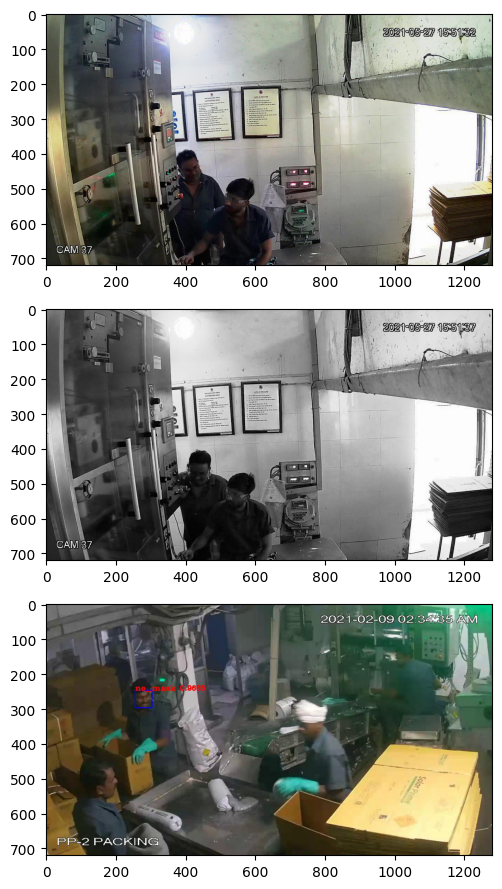

In [287]:
plt.style.use("default")
fig, ax = plt.subplots(3, figsize=(19,9))
ax[0].imshow(test_image_1)
ax[1].imshow(test_image_2)
ax[2].imshow(test_image_3)
fig.tight_layout()
plt.show()

### Na ostatnim zdjęciu widzimy kolejny przypadek zakłócenia zdjęcia przez narysowany na nim pudełko ograniczające zaznaczenie wraz z podpisem etykiety 'no_mask' i jakąś liczbą.

In [75]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import time

##  Rozmiar macierzy reprezentującej jedno zdjęcie: wysokość, szerokość i liczba kanałów (w przypadku RGB = 3, jeśli zdjęcie było czarno-białe, wtedy = 1)

In [708]:
test_image_1.shape

(720, 1280, 3)

# Sprawdzenie podobieństwa między zdjęciami

## Metryki 
## SSIM (https://en.wikipedia.org/wiki/Structural_similarity) - wartości z zakresu [0,1] (im bliżej 1 tym dwa zdjęcia są bardziej podobne)
## MSE - wartości z zakresu [0,oo] (im bliżej 0 tym dwa zdjęcia są bardziej podobne)

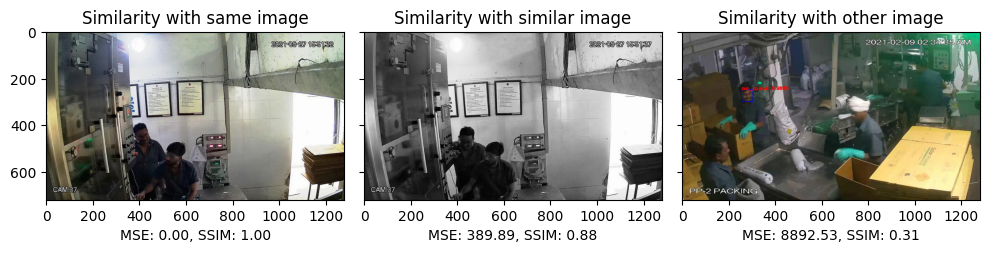

In [288]:
mse_1 = mean_squared_error(test_image_1, test_image_1)
ssim_1 = ssim(test_image_1, test_image_1, data_range=test_image_1.max() - test_image_1.min(), channel_axis=2)

mse_2 = mean_squared_error(test_image_1, test_image_2)
ssim_2 = ssim(test_image_1, test_image_2,
                  data_range=test_image_2.max() - test_image_2.min(), channel_axis=2)

mse_3 = mean_squared_error(test_image_1, test_image_3)
ssim_3 = ssim(test_image_1, test_image_3,
                  data_range=test_image_3.max() - test_image_3.min(), channel_axis=2)
fig, ax= plt.subplots(nrows=1, ncols=3, figsize=(10, 4),
                         sharex=True, sharey=True)

ax[0].imshow(test_image_1, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[0].set_xlabel(f'MSE: {mse_1:.2f}, SSIM: {ssim_1:.2f}')
ax[0].set_title('Similarity with same image')

ax[1].imshow(test_image_2, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[1].set_xlabel(f'MSE: {mse_2:.2f}, SSIM: {ssim_2:.2f}')
ax[1].set_title('Similarity with similar image')

ax[2].imshow(test_image_3, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[2].set_xlabel(f'MSE: {mse_3:.2f}, SSIM: {ssim_3:.2f}')
ax[2].set_title('Similarity with other image')

plt.tight_layout()
plt.show()

In [54]:
df_1280x720 = df_description_train[df_description_train["resolution"] == '1280x720'].reset_index(drop=True)

## Tworzenie listy indeksów SSIM dla wybranego, ustalonego zdjęcia

In [47]:
image_name = '15h_img_263_jpg.rf.5eb821e5fa2267a0104bb0ac8522221c.jpg'

In [51]:
#ustalamy jedno zdjęcie
fix_image = skimage.io.imread(ROOT_PATH+image_name)

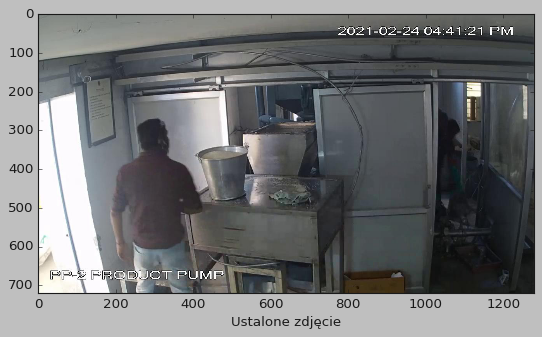

In [53]:
fig, ax = plt.subplots()
ax.imshow(fix_image)
ax.set_xlabel("Ustalone zdjęcie")
plt.show()

## Nasze miary mogą być wyliczane tylko dwóch zdjęć o tych samych rozmiarach, zatem wybieramy ten najczęściej występujący (czyli 1280x720) i tworzymy listę takich zdjęć

In [153]:
x=df_image_train[df_image_train["resolution"]=="1280x720"]
filenames_1280x720_list = list(x["filename"])

#### Liczba zdjęć w formacie 1280x720

In [154]:
len(filenames_1280x720_list)

7813

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import time
import datetime

In [ ]:
image_name = '15h_img_263_jpg.rf.5eb821e5fa2267a0104bb0ac8522221c.jpg'
fix_image = skimage.io.imread(ROOT_PATH+image_name)

mse_list = []
ssim_list = []

print(datetime.datetime.now())
start_time = time.time()

for i in range(len(filenames_1280x720_list)-1):
    image_name = filenames_1280x720_list[i]
    image = skimage.io.imread(ROOT_PATH+image_name)
    
    mse = round(mean_squared_error(fix_image, image), 4)
    ssim_value = round(ssim(fix_image, image,
                  data_range = image.max() - image.min(), channel_axis=2), 4)
    
    mse_list.append(mse)
    ssim_list.append(ssim_value)
    

    if i % 100 == 0:
        print("Loop iteration:", i)

end_time = time.time()
print("Eveluation time:", round(end_time-start_time, 2))

In [172]:
df_test_image_similarities = pd.DataFrame(list(zip(filenames_1280x720_list,ssim_list, mse_list)), columns=["filename", "SSIM", "MSE"])

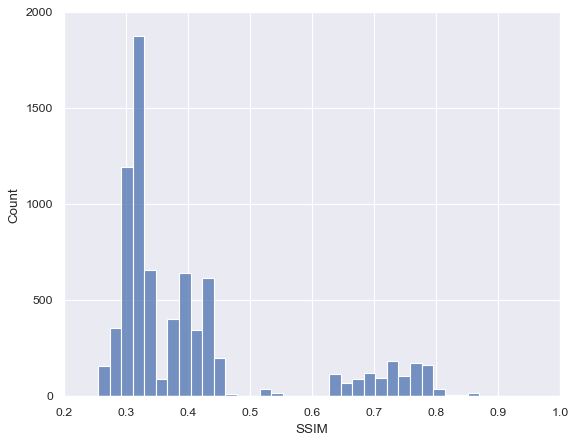

In [177]:
fig, ax = plt.subplots()
sn.histplot(data = df_test_image_similarities, x="SSIM", bins=40)
plt.show()

## Widzimy, że są wyraźnie dwie podgrupy indeksów SSIM: 0.25-0.45 i 0.65-0.8, weźmiemy dla porównania dwa obrazy jeden z wartością SSIM ok. 0.4, a drugi z SSIM ok. 0.65

In [185]:
df_test_image_similarities.loc[[2,7811],:]

filename    SSIM        MSE
2     img273_jpg.rf.78e6836c24c899b455bb6079eb65ae34...  0.4520  5639.1311
7811  p656213152_jpg.rf.c7463dcdb2ca7951763415c71fd4...  0.6549  2925.1853

In [187]:
image_name = df_test_image_similarities["filename"].loc[2]
test_image_1 = skimage.io.imread(ROOT_PATH+image_name)

image_name = df_test_image_similarities["filename"].loc[7811]
test_image_2 = skimage.io.imread(ROOT_PATH+image_name)

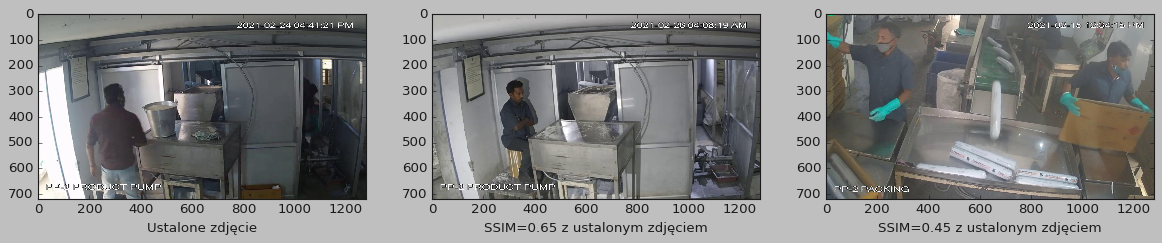

In [196]:
plt.style.use("classic")
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 22))
ax[0].imshow(fix_image)
ax[0].set_xlabel("Ustalone zdjęcie")
ax[1].imshow(test_image_2)
ax[1].set_xlabel("SSIM=0.65 z ustalonym zdjęciem")
ax[2].imshow(test_image_1)
ax[2].set_xlabel("SSIM=0.45 z ustalonym zdjęciem")
plt.show()

### Widać, że zdjęcia z indeksem SSIM = 0.65 są do siebie podobne, są to zdjęcia tego samego miejsca różniące się ustawieniem człowieka, przedmiotów i jasnośćią. Natomiast zdjęcie które ma SSIM = 0.45 z ustalonym zdjęciem jest zrobione z zupełnie innego miejsca. Ta analiza (wraz z przyjrzeniem się histogramowi wyżej) pozwala nam sądzić, że wszystkie zdjęcia z indeksami SSIM powyżej 0.65 były zrobione w tym samym miejscu.

In [200]:
count = len(df_test_image_similarities[df_test_image_similarities["SSIM"]>0.65])
print("Liczba zdjęć, które mają indeks SSIM z ustalonym zdjęciem równym przynajmniej 0.65: ", count )

Liczba zdjęć, które mają indeks SSIM z ustalonym zdjęciem równym przynajmniej 0.65:  1072


### Aż 1072 zdjęcia w grupie zdjęć z tej samej kamery.

## MSE (bardziej znana miara) względem ustalonego zdjęcia

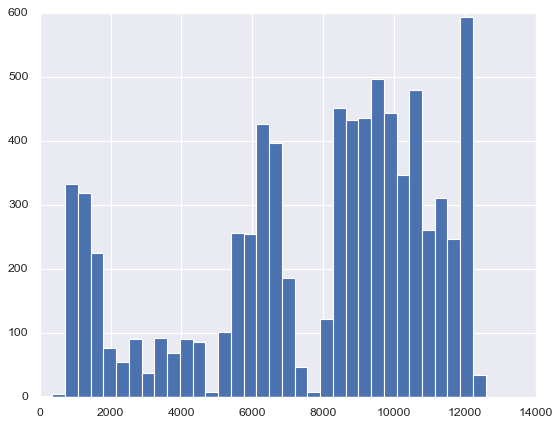

In [168]:
fig, ax = plt.subplots()
ax.hist(mse_list, bins=35)
plt.show()

## Ustalamy inne zdjęcie, poza grupą pierwszego zdjęcia

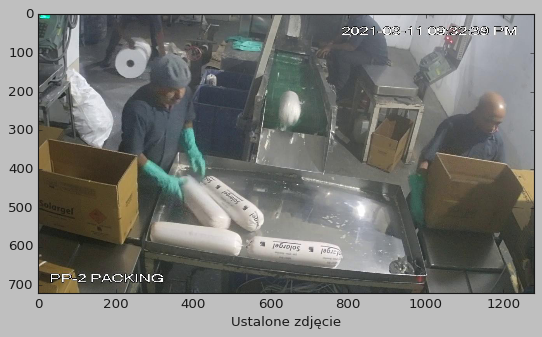

In [203]:
#ustalamy jedno zdjęcie
image_name = 'goggle87656_jpg.rf.5bd8b8346e4e4c37d2066777e6077001.jpg'
fix_image = skimage.io.imread(ROOT_PATH+image_name)
fig, ax = plt.subplots()
ax.imshow(fix_image)
ax.set_xlabel("Ustalone zdjęcie")
plt.show()

In [ ]:
image_name = 'goggle87656_jpg.rf.5bd8b8346e4e4c37d2066777e6077001.jpg'
fix_image = skimage.io.imread(ROOT_PATH+image_name)

mse_list = []
ssim_list = []

print(datetime.datetime.now())
start_time = time.time()

for i in range(len(filenames_1280x720_list)-1):
    image_name = filenames_1280x720_list[i]
    image = skimage.io.imread(ROOT_PATH+image_name)
    
    mse = round(mean_squared_error(fix_image, image), 4)
    ssim_value = round(ssim(fix_image, image,
                  data_range = image.max() - image.min(), channel_axis=2), 4)
    
    mse_list.append(mse)
    ssim_list.append(ssim_value)
    

    if i % 100 == 0:
        print("Loop iteration:", i)

end_time = time.time()
print("Eveluation time:", round(end_time-start_time, 2))


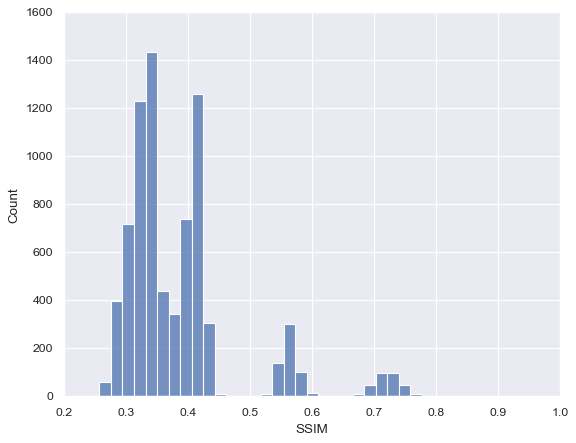

In [206]:
df_test_image_2_similarities = pd.DataFrame(list(zip(filenames_1280x720_list,ssim_list, mse_list)), columns=["filename", "SSIM", "MSE"])
sn.set()
fig, ax = plt.subplots()
sn.histplot(data = df_test_image_2_similarities, x="SSIM", bins=40)
plt.show()

## Tym razem widzimy 3 wyraźne grupy z zakresów indeksów SSIM: 0.25-0.45,  0.55-0.6,  0.68-0.75. Weźmiemy po jednym zdjęciu z każdej z grupy i je porównamy z ustalonym zdjęciem.

In [211]:
df_test_image_2_similarities["filename"].loc[9]   #ssim 0.5622

'nglov107_jpg.rf.78e9e252d1d0a4a37dcac6fe54870539.jpg'

In [ ]:
df_test_image_2_similarities["filename"].loc[14]   #ssim 0.4349

In [ ]:
df_test_image_2_similarities["filename"].loc[6]   #ssim 0.7271 

In [ ]:
image_name = df_test_image_2_similarities["filename"].loc[6]
test_image_1 = skimage.io.imread(ROOT_PATH+image_name)

image_name = df_test_image_2_similarities["filename"].loc[9]
test_image_2 = skimage.io.imread(ROOT_PATH+image_name)

image_name = df_test_image_2_similarities["filename"].loc[14]
test_image_3 = skimage.io.imread(ROOT_PATH+image_name)

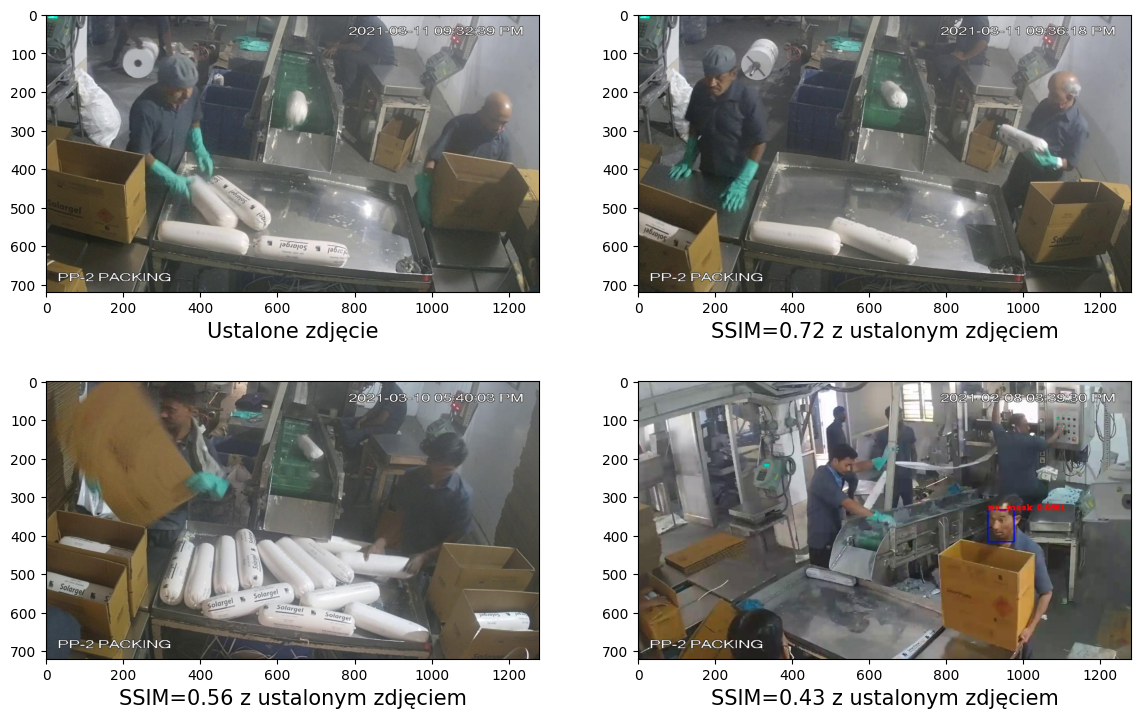

In [242]:
plt.style.use('default')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
ax[0,0].imshow(fix_image)
ax[0,0].set_xlabel("Ustalone zdjęcie", fontsize=15)
ax[0,1].imshow(test_image_1)
ax[0,1].set_xlabel("SSIM=0.72 z ustalonym zdjęciem", fontsize=15)
ax[1,0].imshow(test_image_2)
ax[1,0].set_xlabel("SSIM=0.56 z ustalonym zdjęciem", fontsize=15)
ax[1,1].imshow(test_image_3)
ax[1,1].set_xlabel("SSIM=0.43 z ustalonym zdjęciem", fontsize=15)

plt.subplots_adjust(bottom =0.4)

plt.show()

### Zdjęcie, które ma indeks SSIM = 0.72 z ustalonym obrazem, od razu widać, że zrobione jest w tej samej lokalizacje, jest to zapewne zrzut ekranu z kamery. Zdjęcie z indeksem SSIM = 0.56 również pochodzi z tego samego miejsca, jednakże widać dlaczego ta grupa ma mniejsze wartości - są na nich duże elementy (jak np. karton), które wyraźnie różnią je od ustalonego zdjęcia. Zdjęcie z indeksem SSIM = 0.43 pochodzi z innego miejsca i można założyć, że cała grupa z wartościami poniżej 0.45 także pochodzi z miejsc innych niż ustalone zdjęcie. Dodatkowo warto zwrócić uwagę, że znowu mamy przykład zakłócenia przez pudełko oraz napis na środku zdjęcia.

In [289]:
count = len(df_test_image_2_similarities[df_test_image_2_similarities["SSIM"]>0.65])
print("Liczba zdjęć, które mają indeks SSIM z ustalonym zdjęciem równy przynajmniej 0.65: ", count )

Liczba zdjęć, które mają indeks SSIM z ustalonym zdjęciem równym przynajmniej 0.65:  310


In [295]:
count = len(df_test_image_2_similarities[(df_test_image_2_similarities["SSIM"]>0.5) & (df_test_image_2_similarities["SSIM"]<0.65)])
print("Liczba zdjęć, które mają indeks SSIM z ustalonym zdjęciem między 0.5 i 0.65: ", count )

Liczba zdjęć, które mają indeks SSIM z ustalonym zdjęciem między 0.5 i 0.65:  564


## Zadany zbiór danych ciężko uznać za wystarczający. Przede wszystkim występuje duży problem niezbalansowanych klas, który należy rozwiązać oraz trzeba zająć się transformacją zdjęć do jednej rozdzielczości. Trzeba także przyjrzeć się zdjęciom "zaburzonym" przez np. narysowany na nich bounding box wraz z podpisem (w czasie analizy widoczne były 3 takie zdjęcia, wszystkie one miały podpis kategorii 'no_mask'). Dodatkowo, ogólnie nasz zbiór danych nie jest zbyt różnorodny pod względem np. jasności obrazów. W zbiorze istnieją grupy zdjęć, które są do siebie bardzo podobne - są one zrzutami ekranów z różnych czasów prawdopodobnie tej samej kamery, przez co są one bardzo podobne do siebie. Znaleźliśmy jedną grupę ponad 1000 takich zdjęć, oraz drugą liczącą prawie 900, a prawdopodobnie nie są to jedyne takie grupy. Można uznać, że ten zbiór danych zawiera za mało obrazów reprezentujących różne warunki czy scenariusze, a różnorodność ta jest potrzebna, aby nasz eksperymentalny model mógł nauczyć radzić sobie z sytuacjami różnego typu.